In [95]:
import requests
import pandas as pd 
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
import numpy as np


In [96]:
mensa_suffix = "mg"
from_date = "00:00_20190911"
url = "http://graphite-kom.srv.lrz.de/render?target=transformNull(sumSeries(exclude(ap.ap*-?{mensa}*.ssid.*,\"ssid\\.error$\")))&format=json&from={date}".format(mensa=mensa_suffix, date=from_date)
json = requests.get(url).json()

In [97]:
datapoints = json[0]["datapoints"]

In [98]:
df = pd.DataFrame(datapoints)
df[1], df[0] = df[0], df[1]
df = df.rename(columns={0:"ds",1:"y"})
df["ds"] = pd.to_datetime(df["ds"],unit='s')
df["y"] = np.log(df["y"]+1)

In [99]:
m = Prophet(changepoint_prior_scale=0.02).fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [100]:
future = m.make_future_dataframe(periods=30, freq='H')

In [101]:
future.tail()

,ds
27397,2020-06-23 03:00:00
27398,2020-06-23 04:00:00
27399,2020-06-23 05:00:00
27400,2020-06-23 06:00:00
27401,2020-06-23 07:00:00


In [102]:
forecast = m.predict(future)

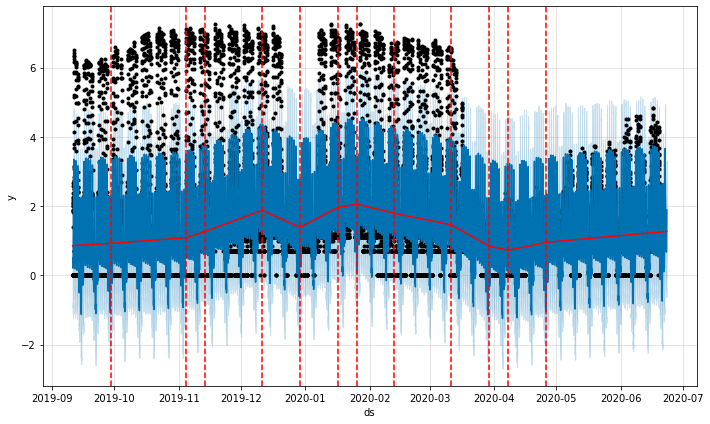

In [103]:
fig1 = m.plot(forecast)
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

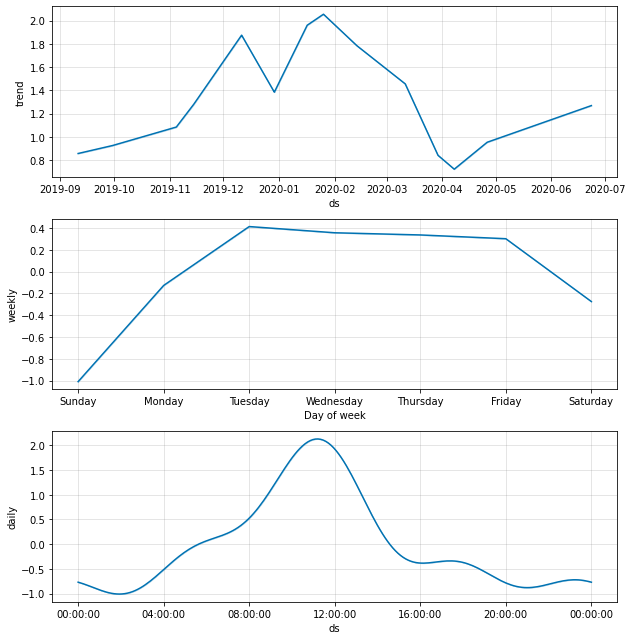

In [104]:
fig2 = m.plot_components(forecast)

In [105]:
future_today = m.make_future_dataframe(periods=24, freq='H', include_history=False)
today_forecast = m.predict(future_today)

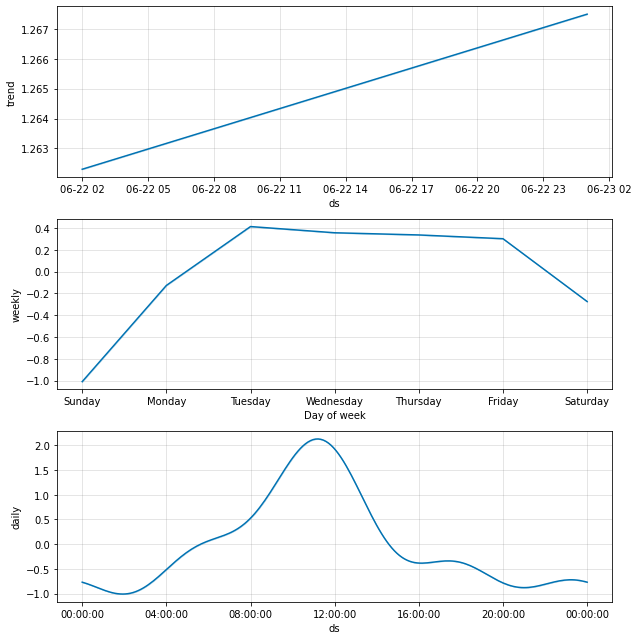

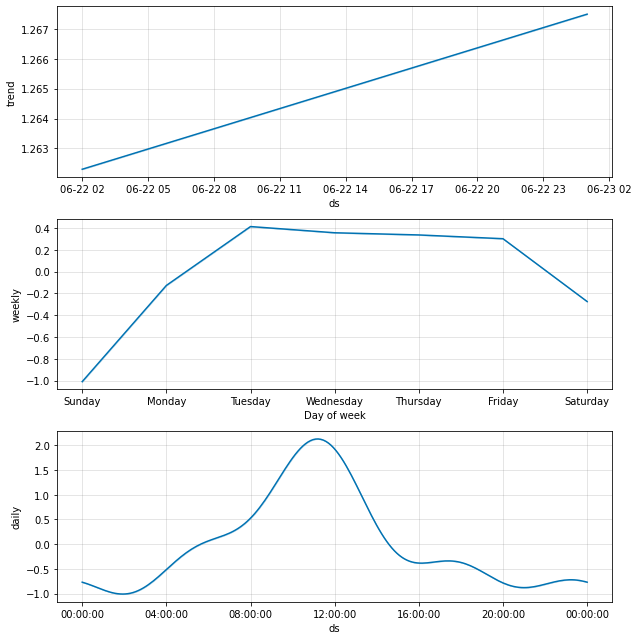

In [106]:
m.plot_components(today_forecast)

In [110]:
today_forecast_only = today_forecast.filter(["ds", "yhat"])

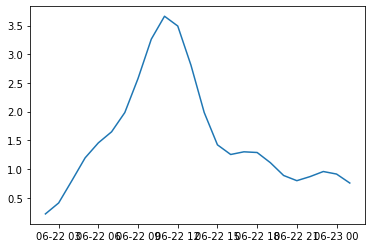

In [113]:
import matplotlib.pyplot as plt

plt.plot(today_forecast_only["ds"], today_forecast_only["yhat"])